# Wavelet Transform Coefficient Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from crypr.data import get_data
from crypr.util import common

from crypr.features.build_features import make_single_feature, series_to_predict_matrix, make_features, data_to_supervised
from crypr.features.wavelets import *

from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
import pywt

import pickle
import gc
p=print

In [29]:
SYM='ETH'
LAST_N_HOURS=16000
TARGET='close'
Tx = 72
Ty = 1
TEST_SIZE=0.05

In [30]:
data = pd.read_csv('../data/raw/{}.csv'.format(SYM), index_col=0)

In [31]:
"""
Get percent change feature and target data.
"""
df=make_single_feature(input_df=data, target_col='close', train_on_x_last_hours=LAST_N_HOURS)
X, y = data_to_supervised(input_df=pd.DataFrame(df['target']), Tx=Tx, Ty=Ty)
p(X.shape, y.shape)
X.head()

(15927, 72) (15927, 1)


,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
28075,0.000000,0.743494,-0.123001,1.354680,-0.243013,-0.121803,-0.121951,0.366300,-0.608273,-0.979192,...,-0.119048,-0.238379,0.358423,-0.119048,-0.119190,0.835322,-0.236686,-0.237248,-0.118906,0.000000
28076,0.743494,-0.123001,1.354680,-0.243013,-0.121803,-0.121951,0.366300,-0.608273,-0.979192,0.865266,...,-0.238379,0.358423,-0.119048,-0.119190,0.835322,-0.236686,-0.237248,-0.118906,0.000000,0.238095
28077,-0.123001,1.354680,-0.243013,-0.121803,-0.121951,0.366300,-0.608273,-0.979192,0.865266,-1.102941,...,0.358423,-0.119048,-0.119190,0.835322,-0.236686,-0.237248,-0.118906,0.000000,0.238095,-0.356295
28078,1.354680,-0.243013,-0.121803,-0.121951,0.366300,-0.608273,-0.979192,0.865266,-1.102941,1.239157,...,-0.119048,-0.119190,0.835322,-0.236686,-0.237248,-0.118906,0.000000,0.238095,-0.356295,0.238379
28079,-0.243013,-0.121803,-0.121951,0.366300,-0.608273,-0.979192,0.865266,-1.102941,1.239157,-0.489596,...,-0.119190,0.835322,-0.236686,-0.237248,-0.118906,0.000000,0.238095,-0.356295,0.238379,0.356718


In [32]:
"""
Confirm data reshape and target/feature creation was done correctly.
"""
y_values_except_last = np.squeeze(y.iloc[:-1].values)
t_minus_1_x_values_except_first = X.iloc[1:,-1].values

y_values_except_last.all() == t_minus_1_x_values_except_first.all()

True

In [33]:
"""
For comparing different transformations
"""
sample_ix = 1000

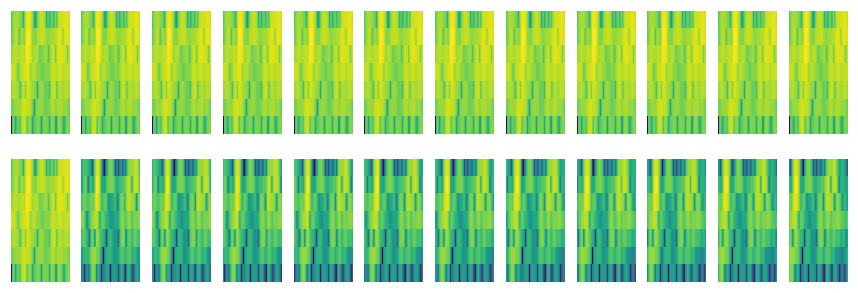

In [34]:
"""
Spectrogram Analysis
"""
rows=2
cols=12
fig, ax = plt.subplots(rows,cols, figsize=(15,5))
for r in range(rows):
    for c in range(cols):
        plt.sca(ax[r][c])
        pxx, freqs, bins, im = plt.specgram(X.iloc[sample_ix+r*c], 12, 1, noverlap=11)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
sns.despine(left=True, bottom=True)
plt.show()

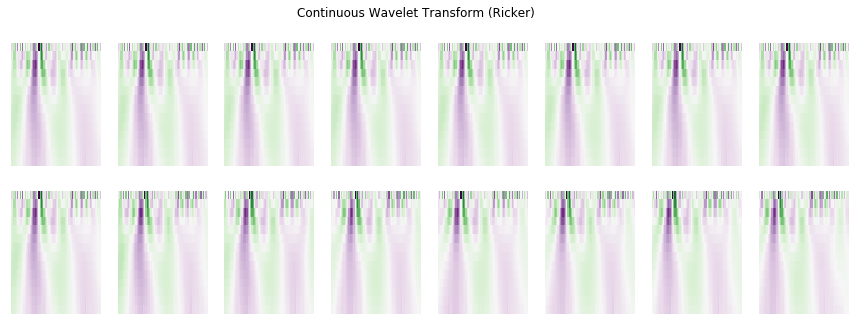

In [35]:
"""
CWT Ricker
"""
N = 14
# T = 1.0 / N
# START=1000
widths=np.arange(1,N+1)

rows=2
cols=8
fig, ax = plt.subplots(rows,cols, figsize=(15,5))
for r in range(rows):
    for c in range(cols):
        plt.sca(ax[r][c])
        cwtmatr = signal.cwt(X.iloc[sample_ix+r*c], wavelet=signal.ricker, widths=widths)
        plt.imshow(cwtmatr, extent=[-1, 1, 1, N+1], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
sns.despine(left=True, bottom=True)
plt.suptitle('Continuous Wavelet Transform (Ricker)')
plt.show() 

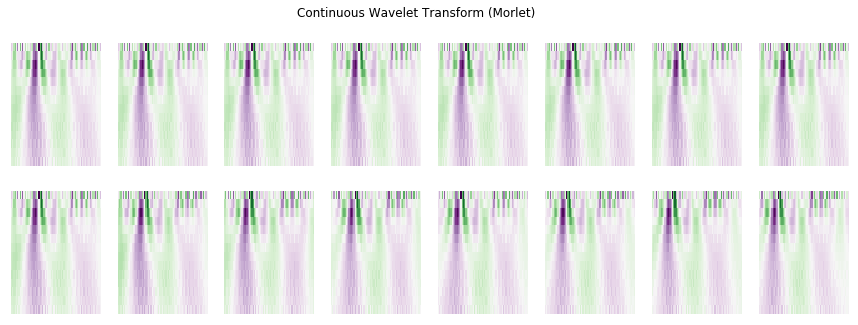

In [36]:
"""
CWT Morlet Transform
"""

rows=2
cols=8

fig, ax = plt.subplots(rows,cols, figsize=(15,5))

for r in range(rows):
    for c in range(cols):
        plt.sca(ax[r][c])
        cwtmatr, freqs = pywt.cwt(X.iloc[sample_ix+r*c], scales=widths, wavelet='mexh')
        plt.imshow(cwtmatr, extent=[-1, 1, 1, N+1], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
sns.despine(left=True, bottom=True)
plt.suptitle('Continuous Wavelet Transform (Morlet)')
plt.show() 

In [37]:
X.shape

(15927, 72)

In [38]:
"""
Apply the wave transformation to the feature data.
"""
wt_type='MORLET'
N = 28
widths=np.arange(1,N+1)

if wt_type == 'RICKER':
    wt_transform_fun = lambda x: signal.cwt(x, wavelet=signal.ricker, widths=widths)
elif wt_type == 'MORLET':
    wt_transform_fun = lambda x: pywt.cwt(x, scales=widths, wavelet='morl')[0]
else:
    p('NOT IMPLEMENTED')
    
X_wt_coef = np.apply_along_axis(func1d=wt_transform_fun, axis=-1, arr=X)

X_wt_coef.shape

(15927, 28, 72)

In [39]:
"""
Train Test Split.
"""
X_train, X_test, y_train, y_test = train_test_split(X_wt_coef, y, test_size=TEST_SIZE, shuffle=False)

In [40]:
"""
Save data.
"""
np.save(arr=X_train, allow_pickle=True, file='../data/processed/X_train_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx))
np.save(arr=X_test, allow_pickle=True, file='../data/processed/X_test_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx))
np.save(arr=y_train, allow_pickle=True, file='../data/processed/y_train_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx))
np.save(arr=y_test, allow_pickle=True, file='../data/processed/y_test_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx))